In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

from draw_strokes import draw_strokes

from lstm import LSTMGenerator, LSTMDiscriminator
from lstm_data import LSTMDataset, create_mask, create_batch_mask, revert

DATA_PATH = "sheep_market.npz"
data = np.load(DATA_PATH, allow_pickle=True, encoding="bytes")
train_raw_data = data["train"]
valid_raw_data = data["valid"]
test_raw_data = data["test"]


In [2]:

EPOCHS = 1
DIM = 4
H_DIM = 16
LAYERS = 4
BATCH_SIZE = 64
LEARNING_RATE = 0.0002
NUM_WORKERS = 8

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 0 if DEVICE == "cpu" else 2

generator = LSTMGenerator(h_dim=H_DIM, dim=DIM, num_layers=LAYERS)
discriminator = LSTMDiscriminator(h_dim=H_DIM, dim=DIM, num_layers=LAYERS)

generator.to(DEVICE)
discriminator.to(DEVICE)

# z = torch.normal(torch.zeros(BATCH_SIZE, H_DIM), 1) # B, H
    
train = LSTMDataset(train_raw_data)
valid = LSTMDataset(valid_raw_data)
test = LSTMDataset(test_raw_data)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

optimizer_generator = optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

criterion = nn.BCEWithLogitsLoss()

# b1 = next(iter(train_loader))
# mask = create_batch_mask(b1)
# z = torch.normal(torch.zeros(BATCH_SIZE, H_DIM), 1) # B, H
# g = generator(z)
# d = discriminator(train[0])


In [3]:
def run_epoch(
        generator,
        discriminator,
        data_loader,
        criterion,
        optimizer_generator,
        optimizer_discriminator,
        device,
        learn,
    ):
        
        dataset_len = len(data_loader.dataset)
        epoch_g_loss = 0.
        epoch_d_loss = 0.
        
        for iter, real_x in enumerate(train_loader):

            with torch.set_grad_enabled(learn):

                real_x = real_x.to(device)

                batch_size = real_x.size(0)
                real_labels = torch.ones(batch_size, 1, device=device)
                fake_labels = torch.zeros(batch_size, 1, device=device)
                
                optimizer_generator.zero_grad()
                z = torch.normal(torch.zeros(batch_size, H_DIM, device=device), 1)
                fake_x = generator(z)

                real_x = real_x * create_batch_mask(real_x)
                fake_x = fake_x * create_batch_mask(fake_x)

                g_loss = criterion(discriminator(fake_x), real_labels)
                if learn:
                    g_loss.backward()
                    optimizer_generator.step()

                optimizer_discriminator.zero_grad()
                real_loss = criterion(discriminator(real_x), real_labels)
                fake_loss = criterion(discriminator(fake_x.detach()), fake_labels)
                d_loss = (real_loss + fake_loss) / 2
                if learn:
                    d_loss.backward()
                    optimizer_discriminator.step()

                epoch_g_loss += g_loss.item() * batch_size
                epoch_d_loss += d_loss.item() * batch_size

        avg_epoch_g_loss = epoch_g_loss / dataset_len
        avg_epoch_d_loss = epoch_d_loss / dataset_len

        return avg_epoch_g_loss, avg_epoch_d_loss


In [4]:
DO_TRAINING = False
if DO_TRAINING:
    train_generator_losses = []
    train_discriminator_losses = []

    validation_generator_losses = []
    validation_discriminator_losses = []

    for epoch in range(EPOCHS):

        print("===="*4, f"Epoch {epoch+1} / {EPOCHS}", "===="*4)
        time_stamp = time.time()

        train_g_loss, train_d_loss = run_epoch(generator, discriminator, train_loader, criterion, optimizer_generator, optimizer_discriminator, DEVICE, learn=True)

        train_generator_losses.append(train_g_loss)
        train_discriminator_losses.append(train_d_loss)

        print(f"Train : Time Elapsed: {(time.time() - time_stamp):6f}")
        print("    G_Loss: {}".format(f"{train_g_loss:.6f}"))
        print("    D_Loss: {}".format(f"{train_d_loss:.6f}"))

        time_stamp = time.time()
        
        validation_g_loss, validation_d_loss = run_epoch(generator, discriminator, train_loader, criterion, optimizer_generator, optimizer_discriminator, DEVICE, learn=False)

        print(f"Validation : Time Elapsed: {(time.time() - time_stamp):6f}")
        print("    G_Loss: {}".format(f"{validation_g_loss:.6f}"))
        print("    D_Loss: {}".format(f"{validation_d_loss:.6f}"))

        validation_generator_losses.append(validation_g_loss)
        validation_discriminator_losses.append(validation_d_loss)


In [5]:
SAVE = False
if SAVE:

    GENERATOR_PATH = "weights/gen.pth"
    DISCRIMINATOR_PATH = "weights/dis.pth"

    generator.save(GENERATOR_PATH)
    discriminator.save(DISCRIMINATOR_PATH)


In [6]:
DIM = 4
H_DIM = 16
LAYERS = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

GENERATOR_PATH = "weights/gen_h16_l4_e30.pth"
generator = LSTMGenerator(h_dim=H_DIM, dim=DIM, num_layers=LAYERS)
generator.load(GENERATOR_PATH)


[[-784 -483 0]
 [-882 -505 -1]
 [-1027 -540 -1]
 [-1210 -574 -1]
 [-1396 -578 -1]
 [-1542 -552 -1]
 [-1633 -527 -1]
 [-1684 -514 -1]
 [-1711 -508 -1]
 [-1726 -506 -1]
 [-1735 -506 -1]
 [-1740 -506 -1]
 [-1743 -506 -1]
 [-1745 -506 -1]
 [-1746 -507 -1]
 [-1747 -507 -1]
 [-1747 -507 -1]
 [-1747 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]
 [-1748 -507 -1]


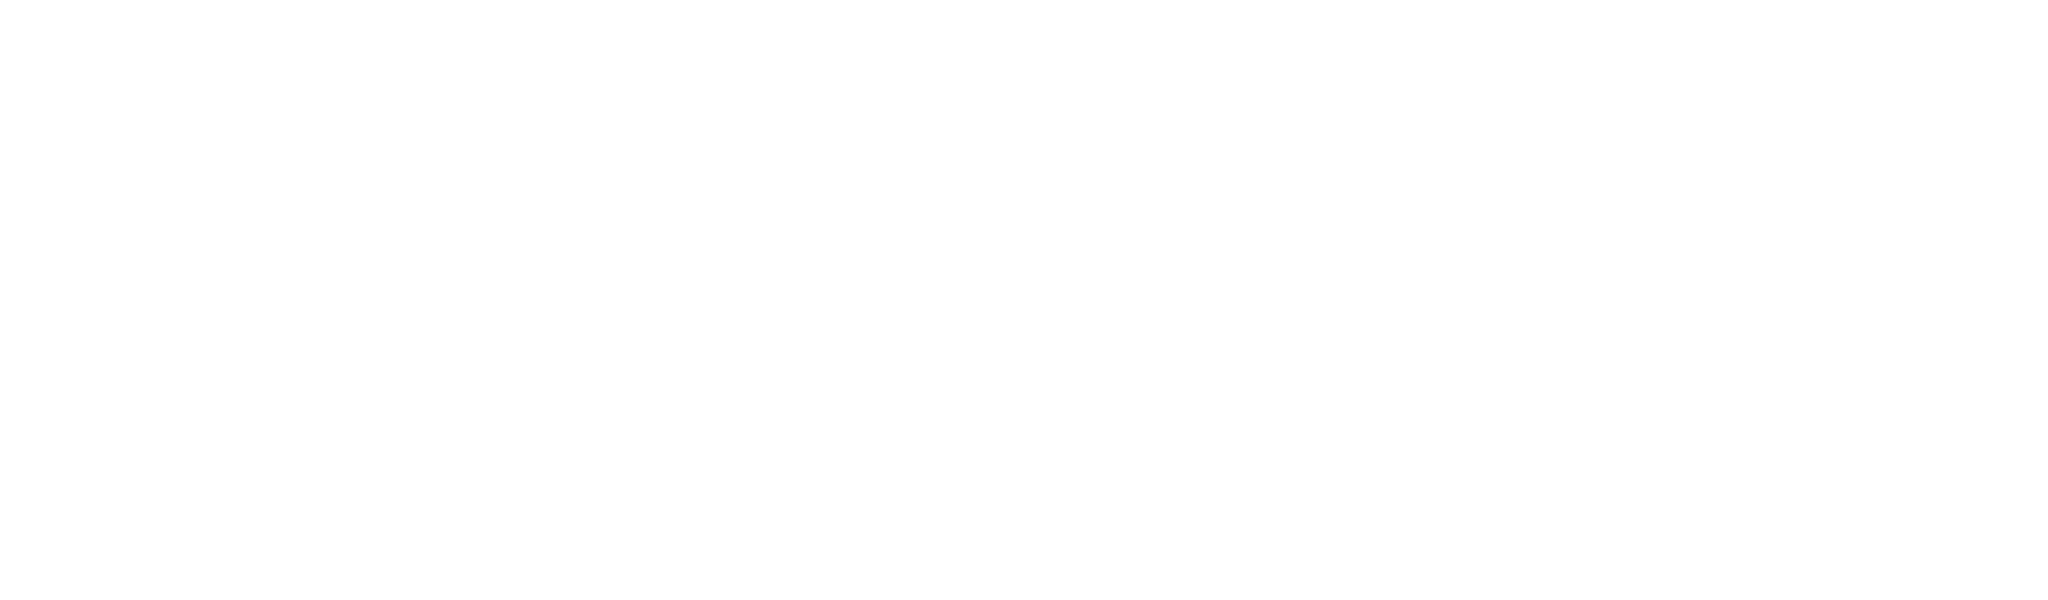

In [9]:
z = torch.normal(torch.zeros(1, H_DIM), 1) # B, H
gen = generator(z)
gen = revert(gen)
print(gen)

# draw_strokes(gen)


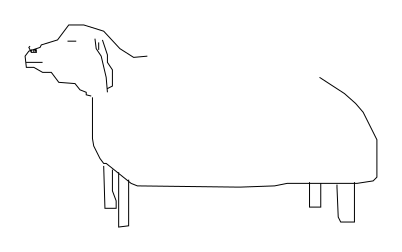

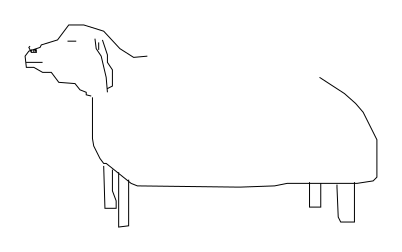

In [8]:
ITEM = 10

rev = revert(train[ITEM])
raw = train_raw_data[ITEM]

draw_strokes(rev)
draw_strokes(raw)
